In [1]:
import sys
from pathlib import Path
import os
sys.path.append(str(Path(os.getcwd()).resolve().parent))

import src.core.utils.load_dataset
import importlib
importlib.reload(src.core.utils.load_dataset)

/home/mikolaj/Desktop/Projects/my_projects/football-ai/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'src.core.utils.load_dataset' from '/home/mikolaj/Desktop/Projects/my_projects/football-ai/src/core/utils/load_dataset.py'>

In [97]:
import supervision as sv
import cv2
import numpy as np
import torch
from typing import Any

# Define annotator objects for visualization
box_annotator = sv.BoxAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000')
)

def plot_images(imgs: list[torch.Tensor], targets: list[dict[str, torch.Tensor]], categories: list[dict[str, Any]]):
    id2label = {}
    for cat in categories:
        id2label[cat['id']] = cat['name']

    annotated_imgs = []  # List of annotated images
    for img, img_targets in zip(imgs, targets):
        # Extract bboxes and class labels
        img_bboxes = img_targets['bboxes']
        img_class_labels = img_targets['labels']
        
        # Convert to numpy array
        img = img.numpy()
        img = img.transpose(1, 2, 0)  # Change the channel position (C, H, W) -> (H, W, C)
        img = np.array(img, dtype=np.uint8)
        img_bboxes = img_bboxes.numpy()
        img_class_labels = img_class_labels.numpy()

        # Images returned by LoadDataset class are in the RGB format, 
        # but the visualization function from supervision requires BGR format because the conversion to RGB is hardcoded within it.
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        labels = [f'{id2label[class_id]}' for class_id in img_class_labels]

        # The default bounding boxes format returned by LoadDataset is x_center, y_center, height, width so we need to convert them to x_min, y_min, x_max, y_max format
        x_min, y_min, w, h = img_bboxes.T
        x_max = x_min + w
        y_max = y_min + h
        img_bboxes = np.stack([x_min, y_min, x_max, y_max], axis=1)

        # Define the Detections object from boxes, scores and class ids
        detections = sv.Detections(
            xyxy=img_bboxes,         # boxes in xyxy format
            class_id=img_class_labels  # class_ids
        )

        # Copy the original image and apply annotations
        annotated_img = img.copy()
        annotated_img = box_annotator.annotate(
            scene=annotated_img,
            detections=detections
        )
        annotated_img = label_annotator.annotate(
            scene=annotated_img,
            detections=detections,
            labels=labels
        )

        # Add annotated image to the list
        annotated_imgs.append(annotated_img)

    sv.plot_images_grid(annotated_imgs, grid_size=(2, 1), size=(20, 20))

In [11]:
def collate_fn(batch):
    images, targets = zip(*batch)
    images = list(images)
    targets = [{k: v for k, v in t.items()} for t in targets]
    return images, targets

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


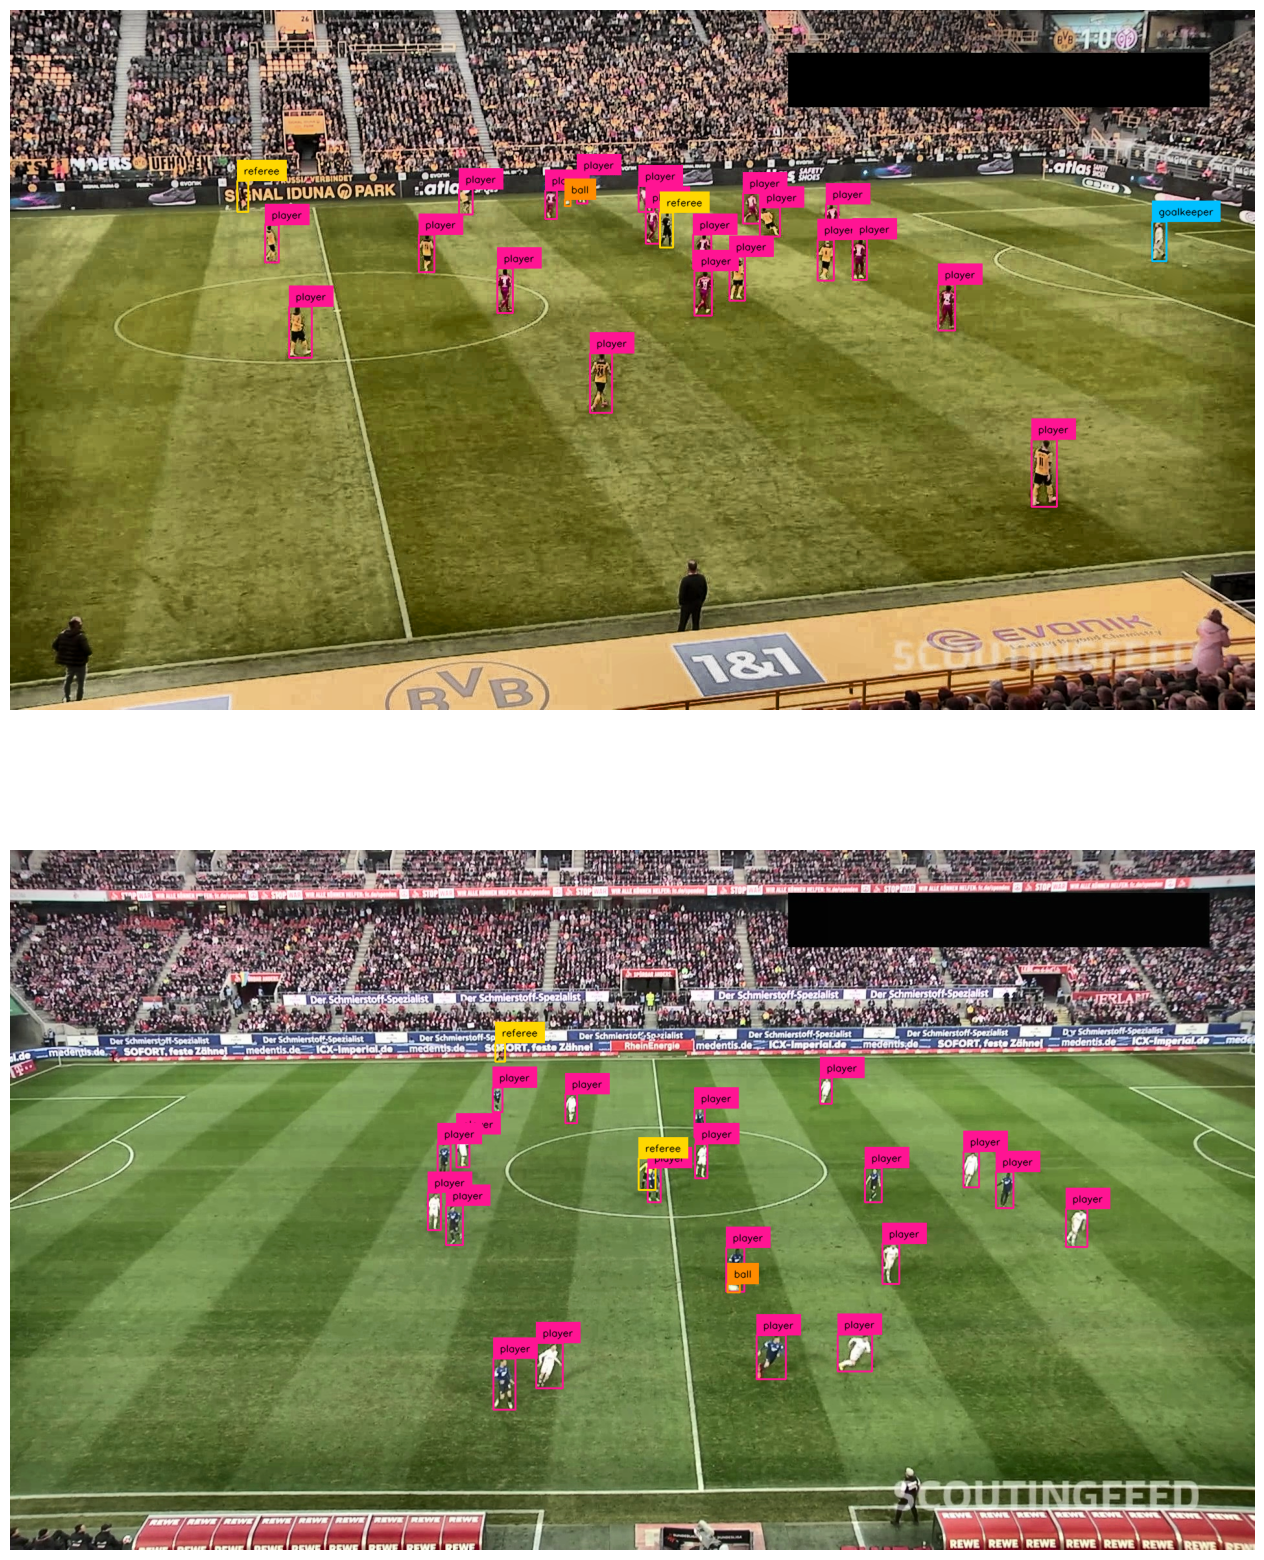

In [ ]:
from src.core.utils.load_dataset import LoadDataset
from torch.utils.data import DataLoader
import albumentations as A
from pathlib import Path
import os

# Path of the project
PROJECT_PATH = Path(os.getcwd()).resolve().parent
# Main data dir
DATA_PATH = PROJECT_PATH / 'data'
# Paths to train, valid and test dir
TEST_PATH = DATA_PATH / 'test'
TEST_IMAGES_PATH = TEST_PATH / 'images'
TEST_ANNOTATIONS = TEST_PATH / 'coco_annotations' / 'annotations.json'


transforms = A.Compose(
    [
        A.HorizontalFlip(p=0.4),
        A.RandomBrightnessContrast(p=0.3),
        A.RandomRotate90(p=0.3),  # Rotacja obrazu o 90 stopni
        A.CLAHE(p=0.5),  # Stosowanie CLAHE
        A.HueSaturationValue(p=0.3)  # Zmiana odcienia, nasycenia i wartości
    ],
    bbox_params=A.BboxParams(format='coco', label_fields=['category_ids'])
)
loader = LoadDataset(TEST_IMAGES_PATH, TEST_ANNOTATIONS, transforms=transforms)
train_dataloader = DataLoader(       # DataLoader object
    loader,                      # train dataset
    batch_size=2,              # number of images in one batch
    shuffle=True,
    collate_fn=collate_fn
)

img, target = next(iter(train_dataloader))
plot_images(img, target, loader.categories)
